In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Flows are coded as (x, y) where +y is upward in the image; value is in pixels

In [35]:
chairs_dataset = raft_datasets.FlyingChairs(
    root='../datasets/FlyingChairs_release/data',
    split='validation', 
    split_file='../chairs_split.txt')
print(len(chairs_dataset))
img1, img2, flow, valid = chairs_dataset[0]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


640


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


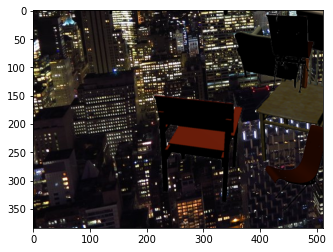

In [36]:
viz(img1)

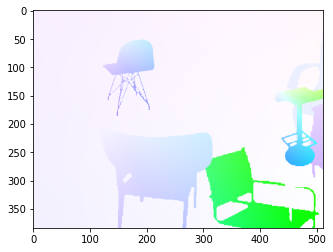

In [70]:
_flow = flow_viz.flow_to_image(tensor_to_arr(flow))
plt.imshow(_flow)

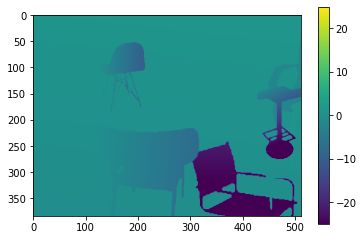

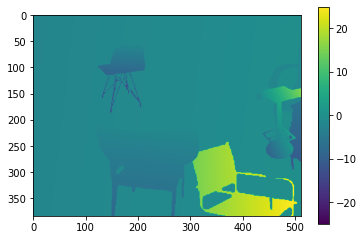

In [93]:
_flow = tensor_to_arr(flow)
plt.imshow(_flow[...,0], vmin=-25, vmax=25)
plt.colorbar()
plt.show()
plt.imshow(_flow[...,1], vmin=-25, vmax=25)
plt.colorbar()
plt.show()

In [400]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    dataset_names=['model_split_4'],    
    filepattern="*",
    test_filepattern="*",
    aug_params={
        'crop_size': [480, 480],
        'min_scale': -0.1,
        'max_scale': 1.0,
        'do_flip': True
    }
)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [363]:
img1, img2, flow, _ = tdw_dataset[1]
print(img1.dtype, img1.shape, flow.dtype, flow.shape)

torch.float32 torch.Size([3, 480, 480]) torch.float32 torch.Size([2, 480, 480])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


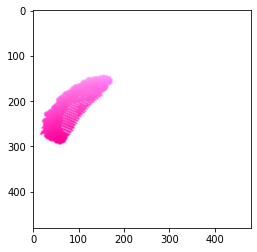

In [368]:
_flow = flow_viz.flow_to_image(tensor_to_arr(flow))
plt.imshow(_flow)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


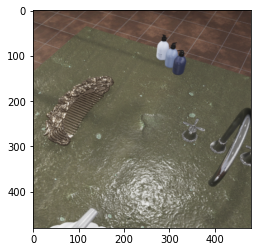

In [367]:
viz(img2)

In [301]:
# flow = raft_datasets.rgb_to_xy_flows(
#     torch.from_numpy(flow).permute(2, 0, 1), False, False
# )

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [302]:
# plt.imshow(tensor_to_arr(flow)[...,0], vmin=-0.1, vmax=0.1)
# plt.show()
# plt.imshow(tensor_to_arr(flow)[...,1], vmin=-0.1, vmax=0.1)
# plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [303]:
flow.max()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.23270496742068386

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


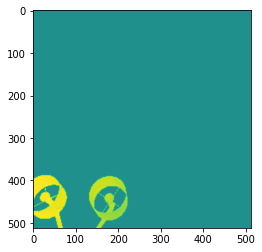

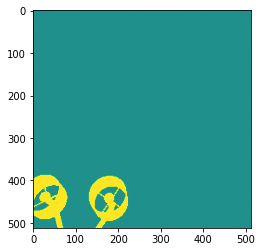

In [304]:
plt.imshow(flow[...,0], vmin=-0.1, vmax=0.1)
plt.show()
plt.imshow(flow[...,1], vmin=-0.1, vmax=0.1)
plt.show()

In [5]:
from bootraft import BootRaft
args = set_args()
# net = torch.nn.DataParallel(RAFT(args))
net = torch.nn.DataParallel(BootRaft(args))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [160]:
ls ../checkpoints/*bootraft*

../checkpoints/10000_bootraft-tdw-noaug.pth
../checkpoints/10000_bootraft-tdw.pth
../checkpoints/15000_bootraft-tdw-noaug.pth
../checkpoints/15000_bootraft-tdw.pth
../checkpoints/20000_bootraft-tdw-noaug.pth
../checkpoints/20000_bootraft-tdw.pth
../checkpoints/5000_bootraft-tdw-noaug.pth
../checkpoints/5000_bootraft-tdw.pth
../checkpoints/bootraft-tdw-noaug.pth
../checkpoints/bootraft-tdw.pth


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
load_path = '../checkpoints/bootraft-tdw-noaug.pth'
net.load_state_dict(torch.load(load_path), strict=False)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

In [7]:
net.cuda()
net.eval()
net.module.freeze_bn()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/primitives_large_v1/',
#     root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
    dataset_names=['model_split_4'],    
#     dataset_names=['model_split_%d' % split for split in range(32)],
    filepattern="*",
    test_filepattern="*",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True
)
print(len(tdw_dataset))

1250


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24]):
    dataset.is_test = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    img1, img2, gt, _ = dataset[ex]
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        pred = flow_viz.flow_to_image(tensor_to_arr(pred))
        preds.append(pred)
    _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(1,2 + len(iters),figsize=(8 + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + ['gt']
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


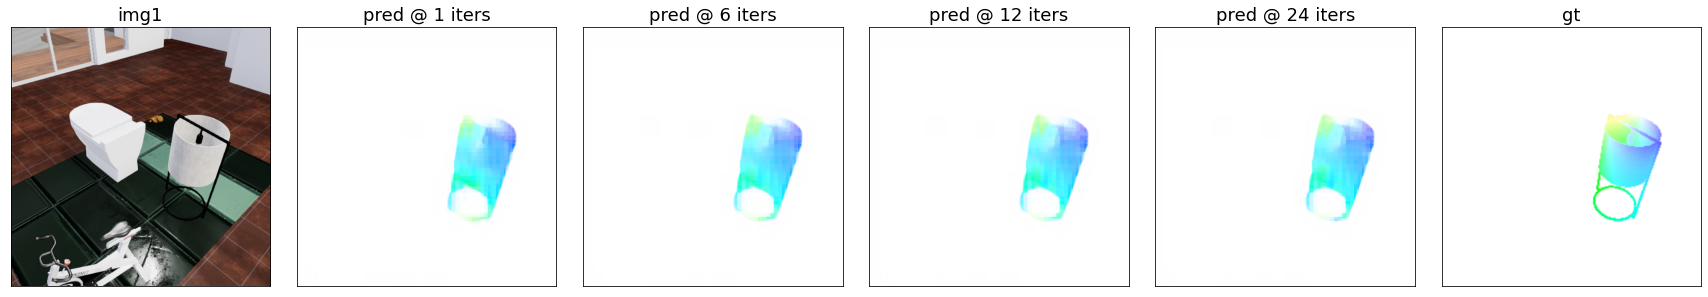

In [162]:
viz_raft_prediction(net, tdw_dataset, ex=41, iters=[1,6,12,24])

In [53]:
def normalize(img):
    return 2.0 * (img / 255.) - 1.0
img1, img2, flow, _ = tdw_dataset[1]
# fmap1, fmap2 = net.module.fnet([normalize(img1[None].cuda()), normalize(img2[None].cuda())])
# ctx = net.module.cnet(img1[None].cuda())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
import corr
corrs = corr.CorrBlock(fmap1, fmap2, num_levels=4, radius=2)
# corrs = corr.CorrBlock(normalize(img1[None,:,::8,::8].cuda()),
#                        normalize(img2[None,:,::8,::8].cuda()), num_levels=4, radius=2)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'fmap1' is not defined

In [235]:
coords0, coords1 = net.module.initialize_flow(img1[None].cuda())
corr = corrs(coords1)
print(corr.shape)

torch.Size([1, 100, 64, 64])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


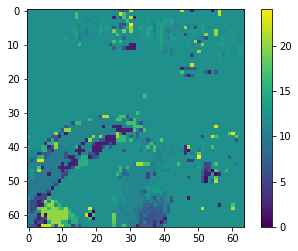

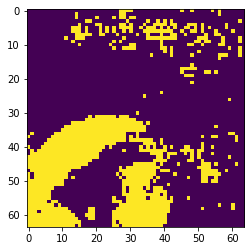

In [236]:
# viz(corr[:,:].max(-3, True)[1])
cs = corr[0].permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(np.argmax(cs[...,:25], -1))
plt.colorbar()
plt.show()

plt.imshow(np.argmax(cs[...,:25], -1) != 12)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


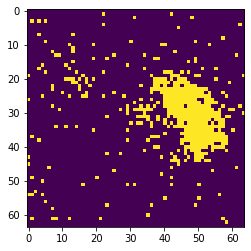

In [164]:
viz(fmap1.max(-3, True)[1] != fmap2.max(-3, True)[1])

In [224]:
img1, img2, flow, _ = tdw_dataset[3]
dcoords, pred = net(img1[None].cuda(), img2[None].cuda(), iters=24, test_mode=True)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


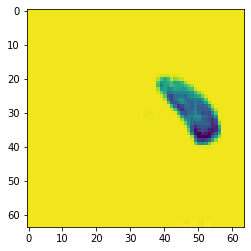

In [164]:
viz(dcoords[:,0:1] * 8)
# plt.colorbar()
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(0.) tensor(1.2270e-16)


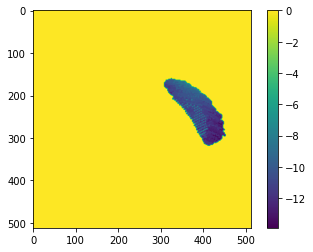

In [165]:
print(flow[0:1].max(), flow[1:2].max())
viz(flow[1:2])
plt.imshow(flow.permute(1,2,0).numpy()[...,1])
plt.colorbar()
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


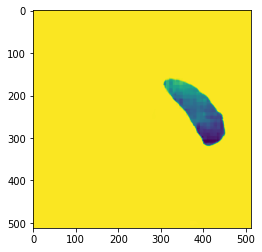

In [166]:
viz(pred[:,0:1])
plt.show()

In [ ]:
img1, img2, flow, _ = tdw_dataset[3]
dcoords, pred = net(img1[None].cuda(), img2[None].cuda(), iters=24, test_mode=True)

In [303]:
list(DEFAULT_CMAP(0.4))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.3269137124539796, 0.1157873496841953, 0.4865864649569746, 1.0]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


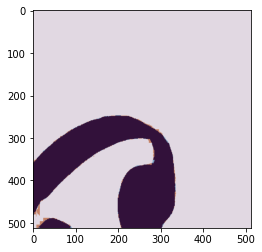

In [19]:
DEFAULT_CMAP = plt.cm.twilight
DEFAULT_ERRMAP_COLORS = {k:float(v)/DEFAULT_CMAP.N for k,v in {'tp': 250, 'tn': 0, 'fp': 420, 'fn': 80}.items()}

def plot_errormap(model, dataset, ex=None, iters=24, thresh=4, 
                  cmap=DEFAULT_CMAP,
                  colors=DEFAULT_ERRMAP_COLORS):
    if ex is None:
        ex = np.random.randint(len(dataset))
    img1, img2, flow, _ = dataset[ex]
    _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)
    
    _seg = lambda x, t: (x.square().sum(-3).sqrt() > thresh).cpu().numpy()[0]
    pred_seg = _seg(pred, thresh)
    gt_seg = _seg(flow[None], 0.5)

    errmap = np.zeros(list(gt_seg.shape) + [3])
    errmap[pred_seg & gt_seg] = list(cmap(colors['tp']))[:3]
    errmap[~pred_seg & ~gt_seg] = list(cmap(colors['tn']))[:3]
    errmap[pred_seg & ~gt_seg] = list(cmap(colors['fp']))[:3]
    errmap[~pred_seg & gt_seg] = list(cmap(colors['fn']))[:3]
    
    plt.imshow(errmap)
    plt.show()

plot_errormap(net, tdw_dataset, ex=11)
    
    

In [ ]:
errmap = np.zeros([512,512,4])
errmap[]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


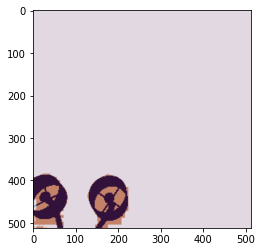

In [298]:
thresh = 1
pred_seg = (pred.square().sum(-3, True).sqrt() > thresh).cpu().numpy()[0,0]
gt_seg = (flow[None].square().sum(-3, True).sqrt() > 0.5).cpu().numpy()[0,0]

# tp = [0.,0.6,0.0]
# tn = [0.8,0.8,0.8]
# fp = [0.8,0.,0.]
# fn = [0.,0.,0.8]

cmap = plt.cm.twilight
N = cmap.N
C = lambda x: cmap((float(x)/N) % 1.0)[:3]

tp = C(250)
tn = C(0)
fp = C(420)
fn = C(80)


errmap = np.zeros((512,512,3))
errmap[pred_seg & gt_seg] = tp
errmap[~pred_seg & ~gt_seg] = tn
errmap[pred_seg & ~gt_seg] = fp
errmap[~pred_seg & gt_seg] = fn

plt.imshow(errmap)
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


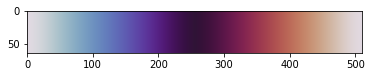

In [275]:
cmap = plt.cm.twilight(range(510))
cmap = np.stack([cmap]*64, 0)
plt.imshow(cmap)

In [67]:
bootraft.layers.num_parameters(net.module.update_block)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3120960

In [68]:
print(net.module.update_block)

BasicUpdateBlock(
  (encoder): BasicMotionEncoder(
    (convc1): Conv2d(324, 256, kernel_size=(1, 1), stride=(1, 1))
    (convc2): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (convf1): Conv2d(2, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (convf2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (gru): SepConvGRU(
    (convz1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convr1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convq1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convz2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convr2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convq2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  )
  (flow_head): FlowHead(
    (conv1): C

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
